# Popularity Analysis

In [6]:
from google.cloud import bigquery
import pandas_gbq
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'snappy-boulder-378707'
pandas_gbq.context.dialect = 'standard'

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', 500)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../BigQuery/letsgo-snappy-boulder-378707-4b7d46801fd1.json"

# Construct a BigQuery client object.
client = bigquery.Client()

from statsmodels.formula.api import ols

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [ ]:
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials
# import json
# import pandas as pd
# from spotipy.oauth2 import SpotifyClientCredentials
# credentials = json.load(open('../authorization.json'))
# client_id = credentials['client_id']
# client_secret = credentials['client_secret']
# client_credentials_manager = SpotifyClientCredentials(client_id=client_id,client_secret=client_secret)
# sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout = 5)

# Import data

## Audio features

In [15]:
%%bigquery audio_feature
SELECT * FROM snappy-boulder-378707.AudioFeatures.AudioFeatures

Query is running:   0%|          |

Downloading:   0%|          |

In [16]:
audio_feature.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'duration_ms', 'time_signature'],
      dtype='object')

In [17]:
audio_feature

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.000,0.000289,0,-26.453,1,0.0000,0.9240,0.959000,0.1110,0.0000,0.000,66tcVcibuPYWs182LeINwu,189600,0
1,0.125,0.126000,0,-16.168,1,0.0364,0.1700,0.836000,0.1070,0.0303,162.399,1QVTJS7UUFWryqJ459TeL2,120000,3
2,0.125,0.031700,0,-23.849,1,0.0397,0.9560,0.819000,0.1250,0.0398,82.889,63LuatqjEm6RW3i469H4W0,846253,4
3,0.125,0.073400,0,-21.889,0,0.0351,0.5530,0.875000,0.1760,0.0347,96.982,7BmRd83zm8CHffrAPe2ZR7,710000,4
4,0.125,0.009780,0,-36.518,1,0.0412,0.9360,0.812000,0.1140,0.0380,72.172,3fwtXQDY5TliCI1CiAqs8U,178983,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74851,0.756,0.913000,11,-3.486,0,0.0523,0.2340,0.000000,0.0431,0.8690,110.955,7g9UMHzfI9w8StnZLVh8jV,196253,4
74852,0.881,0.696000,11,-3.838,0,0.0797,0.1370,0.000041,0.0927,0.7810,97.002,3mQ6SLdxxaL52Yte7KF2Ks,200667,4
74853,0.881,0.361000,11,-14.728,0,0.2370,0.0502,0.004580,0.2460,0.7990,96.430,4HfxDJ0uLHTLe0fZrx0MbQ,216693,4
74854,0.881,0.441000,11,-6.278,0,0.0646,0.4800,0.000009,0.1190,0.8040,138.014,5wfllwdjglyQislkskYLBv,221240,4


## Tracks info

In [19]:
%%bigquery track_info
SELECT * FROM snappy-boulder-378707.TrackClearInfo.TrackClearInfo
WHERE popularity <> 0 and available_markets <> 0

Query is running:   0%|          |

Downloading:   0%|          |

In [23]:
track_info.head()

,id,name,album_id,artist_id,popularity,explicit,available_markets,extract_date
0,01SJW4s3EoRKN3A9mEPM8p,"Two Pieces for 2 pianos, Op. 58: I. Russian Ro...",4F63ZJbW8taPie57Yva3yk,1Ut6lBfgWMEoQZcHw0N6Ca;24kGrCKxX5OW1eq0mNk15V;...,1,0,1,2023-03-24
1,0prvB1hCLNQ2noJHkk7eKk,Adore,0hMWa3WyMRE1kYS9W4B7x6,5mqguTgtaoCMNMZD6txCh6,2,0,1,2023-03-24
2,3f5wbUEe7fR9eUq8Iift2L,Paper Throne,0hMWa3WyMRE1kYS9W4B7x6,5mqguTgtaoCMNMZD6txCh6,2,0,1,2023-03-24
3,6PPI2uXo2PpaoSf0EAu0rP,The Fiddle And The Drum,7k4QpUXGhOvp9U1bHy0OCH,1y2rqr1xpuz2ia93MQ9eEC,2,0,1,2023-03-24
4,7kOkTwCTBX53CRCKn4cbay,Quintessence,0ipDkptOYYaaB2MHXy5VWe,4ze7HHThfzYo15SuunBKhd,2,0,1,2023-03-24


## Merge data

In [97]:
df = pd.merge(audio_feature, track_info, on="id", how="inner")
del df['extract_date']

In [98]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,album_id,artist_id,popularity,explicit,available_markets
0,0.000,0.000289,0,-26.453,1,0.0000,0.924,0.959,0.111,0.0000,0.000,66tcVcibuPYWs182LeINwu,189600,0,Overcome (Alpha Waves),3paWjmhxh5wcMFRumXjtxk,7l8dnU5tDk33Zw78dgfwi5,57,0,184
1,0.125,0.126000,0,-16.168,1,0.0364,0.170,0.836,0.107,0.0303,162.399,1QVTJS7UUFWryqJ459TeL2,120000,3,"Also sprach Zarathustra, Op. 30, TrV 176: I. P...",0PBUx4sIMTkyDSPImmXajW,6pAwHPeExeUbMd5w7Iny6D;09KZU0NsS7jRa5p0SflmGY;...,28,0,184
2,0.125,0.031700,0,-23.849,1,0.0397,0.956,0.819,0.125,0.0398,82.889,63LuatqjEm6RW3i469H4W0,846253,4,Symphony in C Major: II. Andante ma non troppo...,6wcBMJ8IJ0r59oRUqcpxsZ,1C1x4MVkql8AiABuTw6DgE;5DNIeOqK0YF4H6o3GM2k6C;...,20,0,184
3,0.125,0.073400,0,-21.889,0,0.0351,0.553,0.875,0.176,0.0347,96.982,7BmRd83zm8CHffrAPe2ZR7,710000,4,Adagio for Strings and Organ in G Minor,7EvQTMFbqvXw3GSo5F9SZ1,2XVw29JYdo8C5MfteMnCqL;3Fh9zNaErzNE0uHLwrsION;...,40,0,183
4,0.125,0.009780,0,-36.518,1,0.0412,0.936,0.812,0.114,0.0380,72.172,3fwtXQDY5TliCI1CiAqs8U,178983,3,Imagine Peace,42FfOOiJgnOqDWWgUUoD8P,0PzZEo9UXbMwpdcSZcSPfL,26,0,185


# Data Transformation & Preprocessing

In [80]:
numeric_columns = ['danceability', 'energy', 'key', 'loudness', 
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 
       'popularity',  'available_markets']
catego_columns = ['mode','explicit']

In [81]:
imputer_numeric = SimpleImputer(strategy='mean', missing_values=np.nan)
df[numeric_columns] = imputer_numeric.fit_transform(df[numeric_columns])
imputer_catego = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
df[catego_columns] = imputer_catego.fit_transform(df[catego_columns])

In [82]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity,explicit,available_markets
count,74584.000000,74584.000000,74584.000000,74584.000000,74584.000000,74584.000000,74584.000000,74584.000000,74584.000000,74584.000000,74584.000000,7.458400e+04,74584.000000,74584.000000,74584.000000,74584.000000
mean,0.550740,0.491699,5.216722,-11.241498,0.647364,0.071780,0.472483,0.293021,0.165583,0.412051,117.165646,2.229338e+05,3.874222,41.106524,0.077577,177.259546
std,0.186443,0.291694,3.538781,7.767648,0.477794,0.075095,0.373597,0.397194,0.131069,0.254631,31.123494,9.316387e+04,0.461445,15.758553,0.267507,30.949272
min,0.000000,0.000097,0.000000,-47.903000,0.000000,0.000000,0.000000,0.000000,0.007240,0.000000,0.000000,1.594900e+04,0.000000,1.000000,0.000000,1.000000
25%,0.429000,0.242000,2.000000,-14.203000,0.000000,0.035100,0.081700,0.000000,0.097300,0.197000,92.051750,1.714640e+05,4.000000,30.000000,0.000000,184.000000
50%,0.568000,0.506000,5.000000,-8.623000,1.000000,0.044500,0.446000,0.001450,0.114000,0.378000,117.029000,2.103720e+05,4.000000,41.000000,0.000000,184.000000
75%,0.692000,0.739000,8.000000,-5.784000,1.000000,0.070200,0.866000,0.807000,0.179000,0.608000,137.546500,2.541825e+05,4.000000,51.000000,0.000000,185.000000
max,0.984000,1.000000,11.000000,1.519000,1.000000,0.960000,0.996000,0.997000,1.000000,0.987000,237.488000,4.170227e+06,5.000000,100.000000,1.000000,185.000000


## EDA

In [ ]:
from pandas_profiling.visualisation.plot import timeseries_heatmap

timeseries_heatmap(dataframe=df, entity_column='id', sortby='Date Local')

## Correlation between features

<AxesSubplot: >

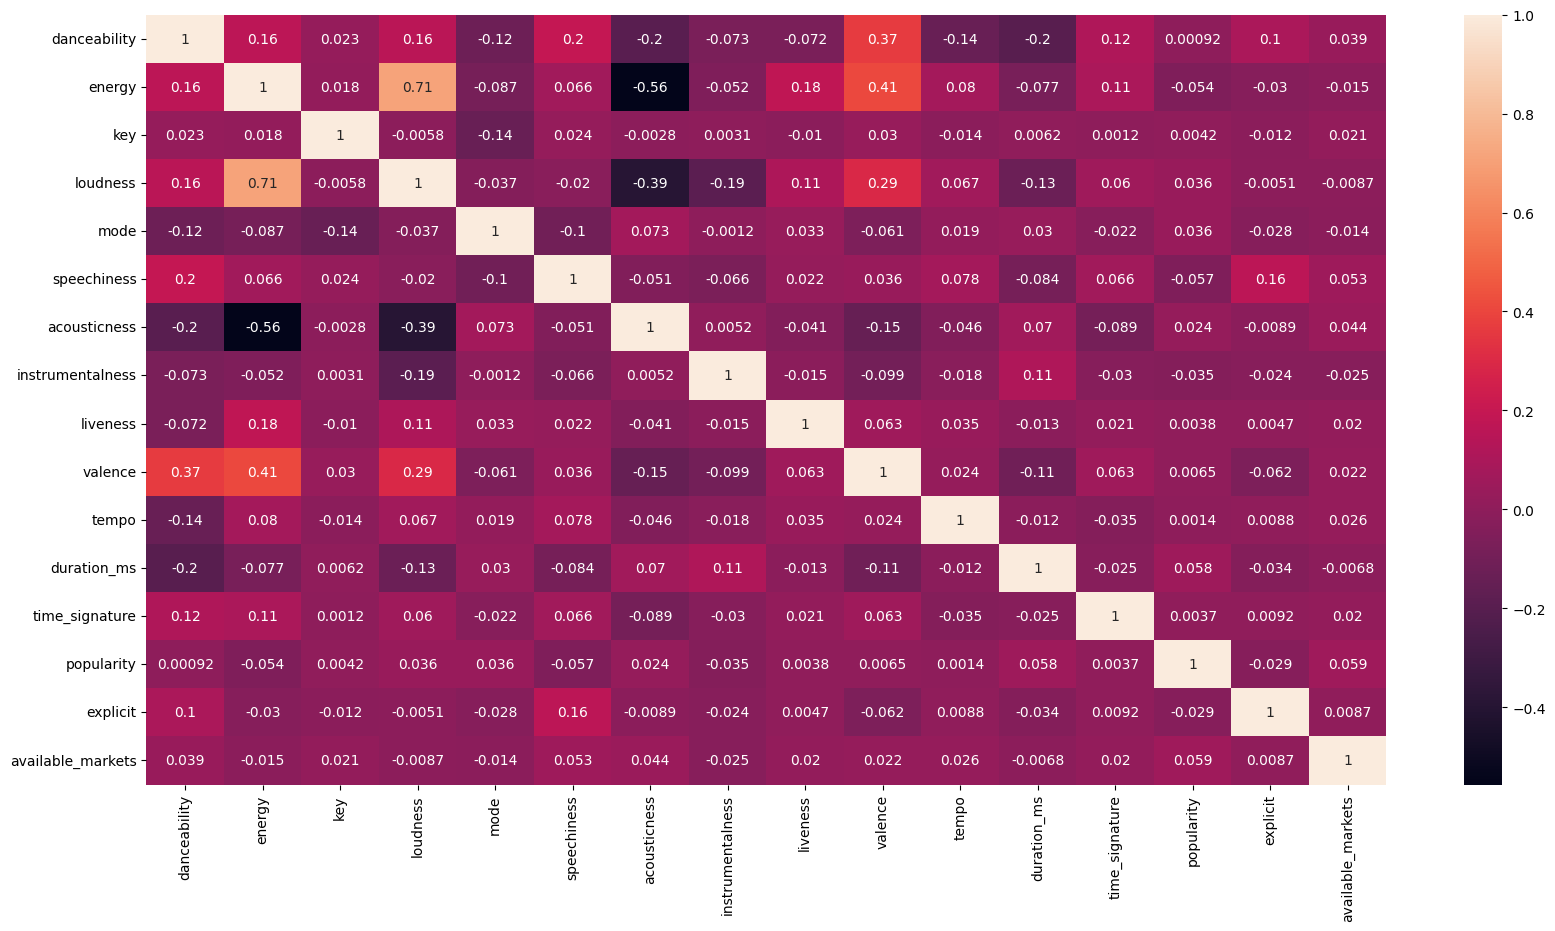

In [84]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)

Observe that loudness and energy has the highest correlation. In future steps, need to eliminate one of variable to compare results

### Distribution of variables

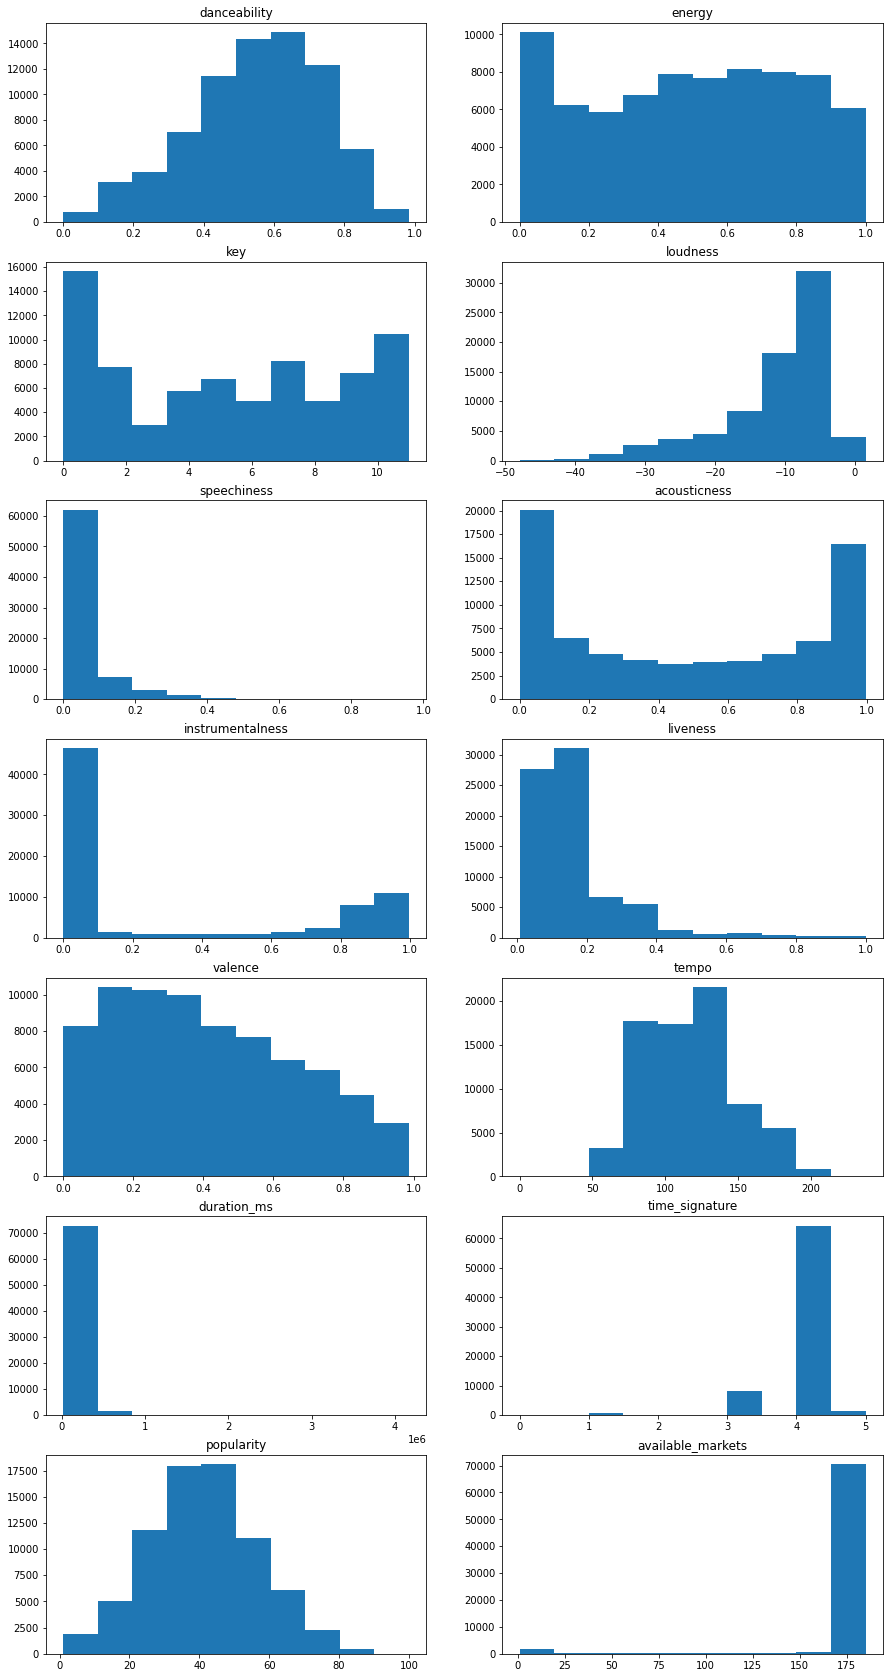

In [95]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(7, 2,figsize=(15,30))
ax1.hist(df[['danceability']])
ax2.hist(df[['energy']])
ax3.hist(df[['key']])
ax4.hist(df[['loudness']])
ax5.hist(df[['speechiness']])
ax6.hist(df[['acousticness']])
ax7.hist(df[['instrumentalness']])
ax8.hist(df[['liveness']])
ax9.hist(df[['valence']])
ax10.hist(df[['tempo']])
ax11.hist(df[['duration_ms']])
ax12.hist(df[['time_signature']])
ax13.hist(df[['popularity']])
ax14.hist(df[['available_markets']])

ax1.title.set_text('danceability')
ax2.title.set_text('energy')
ax3.title.set_text('key')
ax4.title.set_text('loudness')
ax5.title.set_text('speechiness')
ax6.title.set_text('acousticness')
ax7.title.set_text('instrumentalness')
ax8.title.set_text('liveness')
ax9.title.set_text('valence')
ax10.title.set_text('tempo')
ax11.title.set_text('duration_ms')
ax12.title.set_text('time_signature')
ax13.title.set_text('popularity')
ax14.title.set_text('available_markets')

Text(0, 0.5, 'frequency')

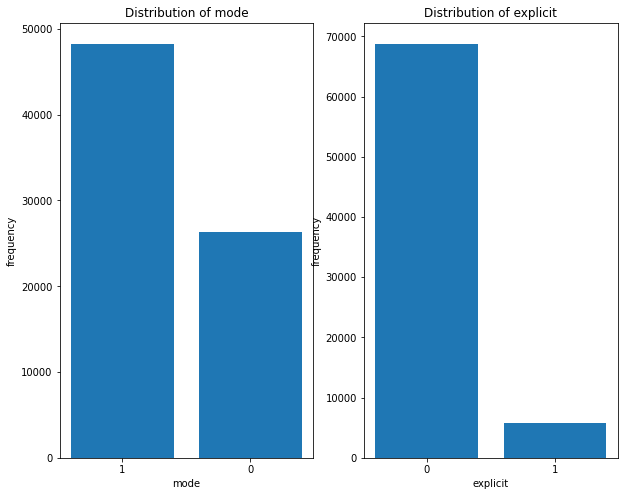

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
ax[0].bar(    
    x=list(map(str,df[catego_columns[0]].value_counts().keys().tolist())),
    height=df[catego_columns[0]].value_counts().values
    )
ax[0].set_title("Distribution of mode")
ax[0].set_xlabel("mode")
ax[0].set_ylabel("frequency")
ax[1].bar(    
    x=list(map(str,df[catego_columns[1]].value_counts().keys().tolist())),
    height=df[catego_columns[1]].value_counts().values
    )
ax[1].set_title("Distribution of explicit")
ax[1].set_xlabel("explicit")
ax[1].set_ylabel("frequency")

## Multilinear regression

In [ ]:
indep_features = ['danceability', 'energy', 'key', 'loudness', 'C(mode)',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature',
        'C(explicit)', 'available_markets']

In [121]:
linear = ols(formula='popularity ~ ' + ' + '.join(indep_features), data=df).fit()
linear.summary()

Text(0, 0.5, 'residuals')

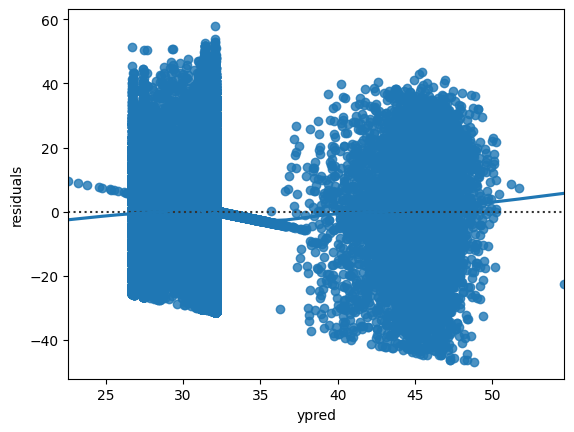

In [124]:
sns.residplot(x=linear.fittedvalues, y=linear.resid, lowess=True)
plt.xlabel('ypred')
plt.ylabel('residuals')

## Log regression

In [125]:
logr = ols(formula='np.log(popularity) ~ ' + ' + '.join(indep_features), data=df).fit()
logr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(popularity)   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     172.6
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:00:14   Log-Likelihood:            -1.3063e+05
No. Observations:              113457   AIC:                         2.613e+05
Df Residuals:                  113439   BIC:                         2.615e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.5416      0.146     24.273      0.000       3.256       3.828
C(mode)[T.1]            0.0130      0.016      0.823      0.410      -0.018       0.044
C(mode)[T.<NA>]        -0.4400      0.013    -32.749      0.000      -0.466      -0.414
C(explicit)[T.1]       -0.0270      0.005     -5.805      0.000      -0.036      -0.018
C(explicit)[T.<NA>]    -0.2159      0.016    -13.439      0.000      -0.247      -0.184
danceability            0.0586      0.063      0.937      0.349      -0.064       0.181
energy                 -0.3180      0.075     -4.227      0.000      -0.465      -0.171
key                     0.0007      0.002      0.308      0.758      -0.004       0.005
loudness                0.0206      0.004      4.728      0.000       0.012       0.029
speechiness            -0.0857      0.076     -1.122      0.262      -0.235       0.064
acousticness            0.0037      0.037      0.100      0.920      -0.069       0.077
instrumentalness       -0.0680      0.082     -0.830      0.407      -0.228       0.093
liveness                0.0216      0.052      0.412      0.680      -0.081       0.124
valence                 0.0418      0.040      1.053      0.293      -0.036       0.120
tempo                   0.0001      0.000      0.447      0.655      -0.000       0.001
duration_ms          1.621e-07      1e-07      1.620      0.105    -3.4e-08    3.58e-07
time_signature          0.0397      0.029      1.370      0.171      -0.017       0.097
available_markets       0.0013   5.46e-05     23.356      0.000       0.001       0.001
==============================================================================
Omnibus:                    38104.899   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124415.618
Skew:                          -1.731   Prob(JB):                         0.00
Kurtosis:                       6.786   Cond. No.                     1.49e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'residuals')

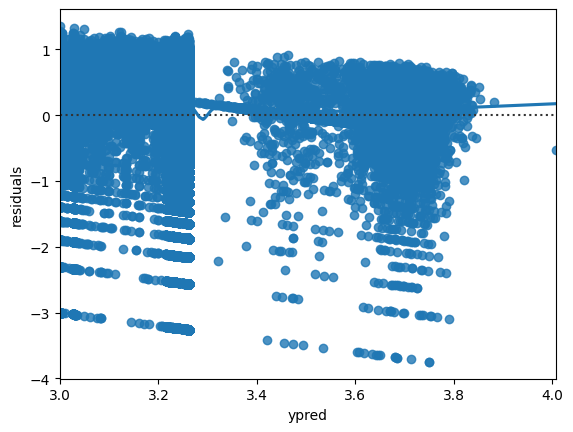

In [126]:
sns.residplot(x=logr.fittedvalues, y=logr.resid, lowess=True)
plt.xlabel('ypred')
plt.ylabel('residuals')

## Polynomial

In [134]:
indep_features = ['danceability', 'energy', 'key', 'loudness','mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature','explicit',
         'available_markets']

In [173]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
p2X_train = poly.fit_transform(df[indep_features])

In [175]:
import statsmodels.api as sm
model = sm.OLS(df['popularity'], p2X_train).fit()

In [177]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     28.88
Date:                Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:38:24   Log-Likelihood:            -4.7821e+05
No. Observations:              113457   AIC:                         9.567e+05
Df Residuals:                  113330   BIC:                         9.579e+05
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.7879     35.928      2.082      0.037       4.369     145.207
x1            -7.5896     26.480     -0.287      0.774     -59.490      44.310
x2           -36.9728     34.177     -1.082      0.279    -103.959      30.014
x3            -0.0165      0.950     -0.017      0.986      -1.878       1.845
x4             0.9646      1.738      0.555      0.579      -2.441       4.371
x5             2.7922      3.343      0.835      0.404      -3.760       9.344
x6            19.8800     30.350      0.655      0.512     -39.605      79.365
x7           -13.2484     16.021     -0.827      0.408     -44.649      18.152
x8           -43.2862     29.694     -1.458      0.145    -101.486      14.914
x9           -81.2787     26.088     -3.116      0.002    -132.411     -30.147
x10           -5.1892     17.267     -0.301      0.764     -39.032      28.654
x11           -0.4901      0.117     -4.191      0.000      -0.719      -0.261
x12        -1.836e-05   5.68e-05     -0.323      0.747      -0.000     9.3e-05
x13            1.4650      8.289      0.177      0.860     -14.781      17.711
x14            1.2752      3.975      0.321      0.748      -6.516       9.066
x15            0.2004      0.090      2.231      0.026       0.024       0.376
x16           26.6945      8.034      3.322      0.001      10.947      42.442
x17          -22.8800     13.315     -1.718      0.086     -48.976       3.216
x18           -0.4729      0.382     -1.236      0.216      -1.223       0.277
x19            0.9979      0.759      1.315      0.189      -0.490       2.486
x20           -5.3144      2.808     -1.893      0.058     -10.817       0.188
x21          -14.1625     13.984     -1.013      0.311     -41.571      13.246
x22            8.9166      6.608      1.349      0.177      -4.036      21.869
x23           27.8637     12.531      2.224      0.026       3.303      52.424
x24           13.6954      9.705      1.411      0.158      -5.326      32.717
x25            4.8509      7.480      0.649      0.517      -9.809      19.511
x26            0.1784      0.049      3.622      0.000       0.082       0.275
x27         1.485e-06   2.52e-05      0.059      0.953   -4.78e-05    5.08e-05
x28           -5.4958      5.037     -1.091      0.275     -15.368       4.376
x29           10.7072      3.314      3.231      0.001       4.212      17.202
x30            0.0002      0.037      0.005      0.996      -0.072       0.073
x31           43.2801     10.952      3.952      0.000      21.814      64.746
x32            0.1595      0.458      0.349      0.727      -0.737       1.056
x33           -1.5572      0.942     -1.653      0.098      -3.404       0.290
x34           -0.4098      3.392     -0.121      0.904      -7.058       6.238
x35          -25.1233     15.764     -1.594      0.111     -56.021       5.774
x3

Text(0, 0.5, 'residuals')

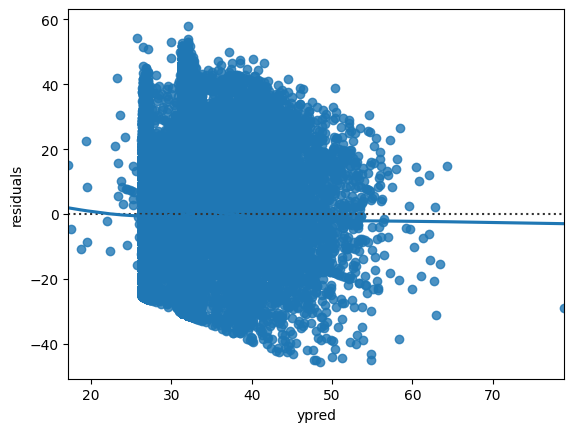

In [178]:
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel('ypred')
plt.ylabel('residuals')

Comparing linear, log-regression, polinomial, the adjusted R-squared of linear regression is the highest. We may use linear regression for the final model